In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data=pd.read_csv('bank_done.csv')
data.shape

(40787, 55)

### 查看样本分布 并画图表示

正样本个数： 36193
负样本个数： 4594


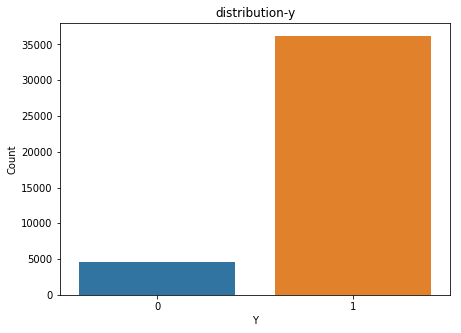

In [17]:
import seaborn as sns
plt.figure(figsize=(7,5))

sns.countplot(x='y',data=data)
plt.title('distribution-y')
plt.xlabel('Y')
plt.ylabel('Count')

print("正样本个数：",data[data['y']==1]['y'].count())
print("负样本个数：",data[data['y']==0]['y'].count())

##  过采样
先划分数据

基于train 做过采样  test 不动  模型测试也是使用原始划分的test

In [18]:
def upData(x_data,y_data):
    # SMOTE 算法,使用imblearn中的over_sampling.SMOTE
    from imblearn.over_sampling import SMOTE
    # 建立SMOTE对象
    oversampler = SMOTE(random_state=0)
    # 生成数据，使得正负样本平衡
    x_data, y_data = oversampler.fit_sample(x_data, y_data)
    # 返回生成后的数据
    return (x_data, y_data)

In [19]:
from sklearn.model_selection import train_test_split

X=data.loc[:,data.columns!='y']
y=data.loc[:,data.columns=='y']

# 先对原始数据集做一个切分
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
print(x_train.shape,y_train.shape)
# 再对过采样数据集做一个切分
# 正采样完 再进行数据集划分   所得到的就是基于采样后的数据
x_data, y_data = upData(x_train, y_train)  # 正采样应该只对训练集作用  不能影响测试集


print(len(x_data[y_data[:]==1]),len(y_data[y_data[:]==0]))
print(type(X),type(y))

(28550, 54) (28550, 1)


/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


25323 25323
<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.frame.DataFrame'>


## planB  先过采样 再分割数据集预测  即均是基于过采样后的数据的

In [23]:
x_data,y_data=upData(X,y)
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.3,random_state=0)

/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 欠采样

对所有数据进行欠采样 由于欠采样后数据变少

所以在欠采样前 先对数据进行划分

欠采样后 再划分  得出训练集 模型训练基于欠采样后的训练集

模型测试基于原始数据的测试集

In [44]:
# import numpy as np
def downData(x_data,y_data):
    # 采用欠采样算法  代表算法 easyEnsemble 
    # 通过对原始的数据集进行随机的下采样实现对数据集进行集成 n_subset 控制子集个数
    from imblearn.ensemble import EasyEnsemble
    downsample=EasyEnsemble(random_state=0)
    x_data,y_data=downsample.fit_sample(x_data,y_data)
    return x_data[0],y_data[0]

In [45]:
# 先对原始数据集做一个切分
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)
# 下采样  由于下采样后数据集变少 所以还是训练集用这个  测试集用原来的
x_data, y_data = downData(X, y)
x_train_d,x_test_d,y_train_d,y_test_d\
    =train_test_split(x_data,y_data,test_size=0.3,random_state=0)
print(len(y_train_d[y_train_d[:]==1]),len(y_train_d[y_train_d[:]==0]))
print(x_data.shape,y_data.shape)

/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


3211 3220
(9188, 54) (9188,)


## LR

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,recall_score,precision_score,f1_score

lr=LogisticRegression()
lr.fit(x_data,y_data)

y_pred=lr.predict(x_test)

print("模型评估：")
print("F1 score:",f1_score(y_test,y_pred))
print("Recall:",recall_score(y_test,y_pred))
print("Precision:",precision_score(y_test,y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

模型评估：
F1 score: 0.9230319563522993
Recall: 0.871573137074517
Precision: 0.9809484365293021
Accuracy: 0.8708833864509276
             precision    recall  f1-score   support

          0       0.46      0.87      0.60      1367
          1       0.98      0.87      0.92     10870

avg / total       0.92      0.87      0.89     12237



## 判断是否过拟合
learn curse 学习曲线 查看在训练集和测试集上的拟合状态 判断是否过拟合

过拟合: 训练集上表现好 测试集上不好

欠拟合: 欠拟合（训练集和测试集的score都不高）

In [7]:

X1=X.as_matrix()
y1=y.as_matrix()
print(type(X1),type(y1))


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/Users/crq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/crq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:

from __future__ import print_function
from sklearn.model_selection import  learning_curve
from sklearn.datasets import load_digits
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
'''
digits = load_digits()
X = digits.data
y = digits.target
'''
train_sizes, train_loss, test_loss= learning_curve(
        SVC(gamma=0.01), X1, y1, cv=10, scoring='mean_squared_error',
        train_sizes=[]
        )
'''
train_loss_mean = -np.mean(train_loss, axis=1)
test_loss_mean = -np.mean(test_loss, axis=1)

plt.plot(train_sizes, train_loss_mean, 'o-', color="r",
             label="Training")
plt.plot(train_sizes, test_loss_mean, 'o-', color="g",
             label="Cross-validation")

plt.xlabel("Training examples")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()
'''


<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/Users/crq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/crq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
from sklearn.model_selection import learning_curve
# np.linspace  参数： start stop num 通过置顶范围和元素数量来创建数组
'''
ylim: tuple 格式的(ymin,ymax) 设定图像中纵坐标的最低点和最高点
train_size: 将用于的训练样本的相对或绝对数量
         产生学习曲线。 
verbose: 详细
'''
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=None,n_jobs=1,
               train_sizes=np.linspace(.05,1.,20),verbose=0,plot=True):
    train_sizes,train_scores,test_scores=learning_curve(
        estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,verbose=verbose
    )
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    if plot:
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel(u"Training examples")
        plt.ylable(u"Score")
        plt.gca().invert_yaxis()
        plt.grid()
        
        plt.fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,
                         alpha=0.1,color='b')
        plt.fill_between(train_sizes,test_scores_mean-test_scores_std,test_scores_mean+test_scores_std,
                         alpha=0.1,color='r')
        
        plt.plot(train_sizes,train_scores_mean,'o-',color='b',label=u"Training score")
        plt.plot(train_sizes,test_scores_mean,'o-',color='r',label=u"Cross-validation score")
        
        plt.legend(loc="best")
        
        plt.draw()
        plt.gca().invert_yaxis()
        plt.show()
        cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
        midpoint=((train_scores_mean[-1]+train_scores_std[-1])+(test_scores_mean[-1]-train_scores_std[-1]))/2
        diff=(train_scores_mean[-1]+train_scores_std[-1])
        return midpoint,diff

plot_learning_curve(lr,"Learning Curves",X.as_matrix(),y.as_matrix())


## 绘制学习曲线 learning_curve

Automatically created module for IPython interactive environment


/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


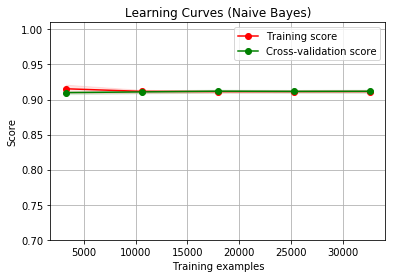

In [9]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
#estimator = SVC(gamma=0.001)
estimator=lr
plot_learning_curve(estimator, title, X1, y1, (0.7, 1.01), cv=cv, n_jobs=4)

plt.show()

学习曲线主要通过 限制数据集大小  来判断模型状态
可以看到模型效果良好  并未处于过拟合还是欠拟合的状态

## 使用交叉验证 获得最好的参数

逻辑回归  主要调整 参数 是C 惩罚项系数  及 penalty  正则化方式  

C：正则化强度的反，值越小正则化强度越大

## cross_val_score: 对数据集进行制定次数的交叉验证 并为每次验证效果评测

0.8725099986318406


0.8793551024764874


0.8810150127983023


0.881019782668319


0.8809921740946436


0.8810064979495424


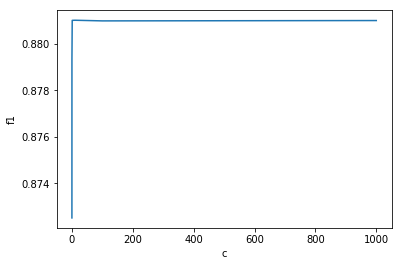

In [8]:
from sklearn.model_selection import cross_val_score
c_params_range=[0.01,0.1,1,10,100,1000]
cv_scores=[]

for c in c_params_range:
    lr=LogisticRegression(C=c,penalty='l1')
    scores=cross_val_score(lr,x_data,y_data,cv=5,scoring='f1')
    cv_scores.append(scores.mean())# 10次交叉验证  取平均值作为这次训练的score
    print(scores.mean())

plt.plot(c_params_range,cv_scores)

plt.xlabel('c')
plt.ylabel('f1')
plt.show()

可以看到  c=1 时 对应的模型效果最好
验证l2 效果好 还是l1 效果好

0.8768748514945708


0.8796055541382396


0.8810110670177165


0.8810555717670386


0.8811084738114575


0.8811084738114575


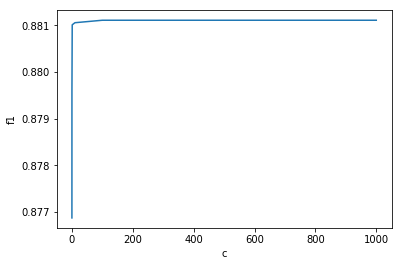

In [9]:
from sklearn.model_selection import cross_val_score
c_params_range=[0.01,0.1,1,10,100,1000]
cv_scores=[]

for c in c_params_range:
    lr=LogisticRegression(C=c,penalty='l2')
    scores=cross_val_score(lr,x_data,y_data,cv=5,scoring='f1')
    cv_scores.append(scores.mean())# 10次交叉验证  取平均值作为这次训练的score
    print(scores.mean())

plt.plot(c_params_range,cv_scores)

plt.xlabel('c')
plt.ylabel('f1')
plt.show()
    

其实整体来说没有很大区别  但看来貌似是 l2 的效果更好一点  且C=100  对应效果更好

### 尝试调整threadhold  看看其对模型的影响

In [10]:
# 定义混淆矩阵回执函数

import itertools
def plot_confusion_matrix(conf_mat,classes,title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(conf_mat,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    # 横轴刻度值  认为设置刻度
    plt.xticks(tick_marks,classes,rotation=0)
    plt.yticks(tick_marks,classes)
    
    thresh=conf_mat.max()/2
    for i,j in itertools.product(range(conf_mat.shape[0]),range(conf_mat.shape[1])):
        plt.text(j,i,conf_mat[i,j],horizontalalignment='center', color='white' if conf_mat[i,j] > thresh else 'black')
   
    plt.tight_layout()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


f1: 0.9437712492372069
f1: 0.946033696033696


f1: 0.9478429985855729


f1: 0.9499621262754534
f1: 0.9505484625067433


f1: 0.9496252555076086
f1: 0.9480771004334594


f1: 0.9381735677821894
f1: 0.912395061728395


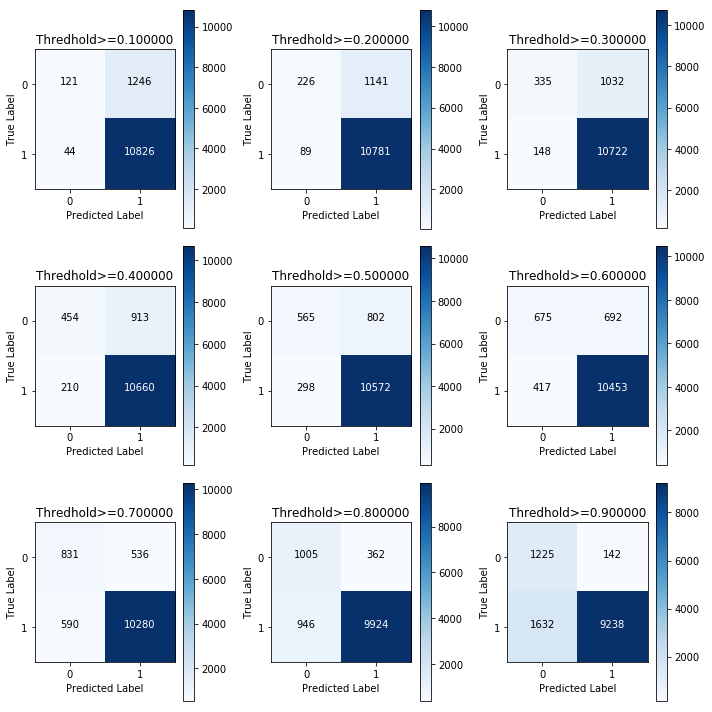

In [11]:
from sklearn.metrics import confusion_matrix,roc_curve
lr=LogisticRegression(C=10)
lr.fit(x_train,y_train)
y_pred_proba=lr.predict_proba(x_test)

threadholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=[10,10])

j=1
for threadhold in threadholds:
    y_pred_f1=y_pred_proba[:,1]>threadhold
    
    plt.subplot(3,3,j)
    j+=1
    cnf_matrix=confusion_matrix(y_test,y_pred_f1)
    np.set_printoptions(precision=2) # 设置小数点后的精度
    
    recall=cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1])
    precision=cnf_matrix[1,1]/(cnf_matrix[0,1]+cnf_matrix[1,1])
    f1=2*precision*recall/(precision+recall)
    print("f1:",f1)
    classes=[0,1]
    plot_confusion_matrix(cnf_matrix,classes,title='Thredhold>=%f'%threadhold)

可以看到 threadhold 还是0.5 最好

重新使用最好的参数预测

In [21]:
import time
lr=LogisticRegression(C=100,penalty='l2',tol=1e-6)
start_time=time.time()
lr.fit(x_data,y_data)
end_time=time.time()
y_pred=lr.predict(x_test)

print("It took %d seconds to train the model"%(end_time-start_time))
print()

print("模型评估：")
print("F1 score:",f1_score(y_test,y_pred))
print("Recall:",recall_score(y_test,y_pred))
print("Precision:",precision_score(y_test,y_pred))
print("Accuracy:",accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

It took 1 seconds to train the model

模型评估：
F1 score: 0.9231293842556507
Recall: 0.8716651333946642
Precision: 0.9810519776351212
Accuracy: 0.8710468252022554
             precision    recall  f1-score   support

          0       0.46      0.87      0.60      1367
          1       0.98      0.87      0.92     10870

avg / total       0.92      0.87      0.89     12237



### 在本数据集上差别不大 但是还是优化了

绘制ROC AUC 曲线

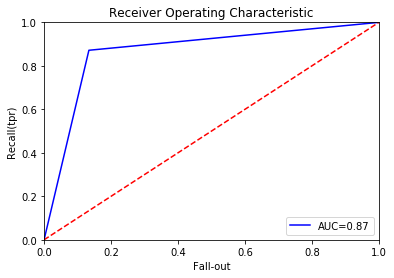

In [22]:
from sklearn.metrics import roc_curve,auc
fpr,tpr,threadholds=roc_curve(y_test,y_pred)

roc_auc=auc(fpr,tpr) # auc 是roc 曲线下夹面积

plt.title('Receiver Operating Characteristic')
plt.plot(fpr,tpr,'b',label='AUC=%0.2f' % roc_auc) # label 定义要显示的标签
plt.legend(loc='lower right') #  legend 显示图中标签 在右下角
plt.plot([0,1],[0,1],'r--') # r-- 红色虚线 前面的是指定坐标范围 0到1 0 到1 
plt.xlim([0.0,1.0])# xlim 设置横坐标范围
plt.ylim([0.0,1.0])
plt.ylabel('Recall(tpr)')
plt.xlabel('Fall-out')
plt.show()

In [30]:
# 查看相关系数
print(len(list(data.columns)[1:]),len(list(lr.coef_.T)))
print(data.shape)
pd.DataFrame({"columns":list(data.columns)[1:],"coef":list(lr.coef_.T)})



54 54
(40787, 55)


,columns,coef
0,education,[0.020830916057080803]
1,duration,[-0.039686333288900304]
2,campaign,[-1.9303558002788426]
3,pdays,[0.1991387662305697]
4,previous,[0.04955034693262366]
5,emp.var.rate,[0.01663021972748147]
6,cons.price.idx,[4.461297117664424]
7,cons.conf.idx,[-2.0096704194704205]
8,euribor3m,[-0.12782871047822572]
9,nr.employed,[-1.050124304889652]


# 其他模型调参

 1. SVM

    gamma: 控制高斯核的宽度，决定了点与点之间'靠近'是指多大的距离。
    C:正则化参数
 2. Decision Tree
    
    决策树可以采用 预剪枝和后剪枝来防止过拟合
    sklearn 中只实现了预剪枝
    预剪枝限制条件包括：
    限制树的最大深度
    限制叶节点的最大数目
    规定一个节点中数据点的最小数目防止继续划分
 3. Random Forest

    n_estimators:  该参数越大越好
    max_features: 决定每棵树的随机性大小，较小可以降低过拟合，一般使用默认值
    预剪枝选项：如max_depth 等

# RF 
随机森林

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

params={'min_samples_split':[3,6,9],'n_estimators':[10,50,100]}
grid=GridSearchCV(RandomForestClassifier(),param_grid=params,cv=5)
start_time=time.time()
grid.fit(x_data,y_data)
end_time=time.time()

print("It took %d seconds to train the model"%(end_time-start_time))
print()

# 打印 得分值 最好参数 最好分数
grid.grid_scores_,grid.best_params_,grid.best_score_


/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


It took 132 seconds to train the model



/Users/crq/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:762: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.94760, std: 0.03035, params: {'min_samples_split': 3, 'n_estimators': 10},
  mean: 0.95058, std: 0.03517, params: {'min_samples_split': 3, 'n_estimators': 50},
  mean: 0.95172, std: 0.03421, params: {'min_samples_split': 3, 'n_estimators': 100},
  mean: 0.94681, std: 0.03108, params: {'min_samples_split': 6, 'n_estimators': 10},
  mean: 0.94860, std: 0.03532, params: {'min_samples_split': 6, 'n_estimators': 50},
  mean: 0.94955, std: 0.03377, params: {'min_samples_split': 6, 'n_estimators': 100},
  mean: 0.94278, std: 0.03301, params: {'min_samples_split': 9, 'n_estimators': 10},
  mean: 0.94752, std: 0.03238, params: {'min_samples_split': 9, 'n_estimators': 50},
  mean: 0.94809, std: 0.03142, params: {'min_samples_split': 9, 'n_estimators': 100}],
 {'min_samples_split': 3, 'n_estimators': 100},
 0.951723729415946)

## 基于y衡量  和y最相关的10个特征

使用selectKBest 方法

这里仅仅做用法演示  实际的话 应该将所有的sex归为一类等 去查看相关系数的分布 上面基于lr模型的重要性查看同理

/Users/crq/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  


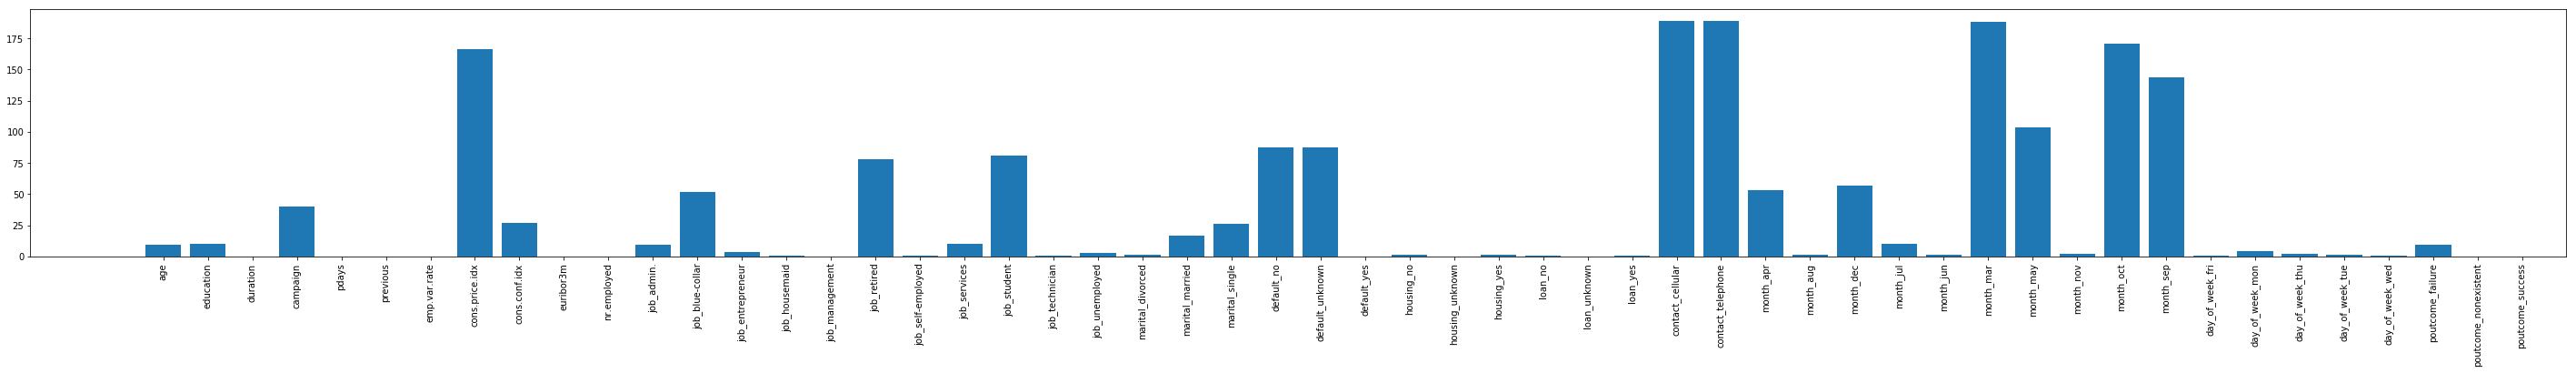

In [8]:
from sklearn.feature_selection import SelectKBest,f_classif
temp=data.drop('y',axis=1)
preditors=temp.columns.values

selector=SelectKBest(f_classif,5)
selector.fit(data[preditors],data['y'])

scores=-np.log10(selector.pvalues_)

# plot
plt.figure(figsize=(50,5))
plt.bar(range(len(preditors)),scores)
plt.xticks(range(len(preditors)),preditors,rotation='vertical')

plt.show()

## 模型融合 集成算法
分类问题：voting
回归问题：average
简单使用模型结果的voting 进行模型融合

对于更高级的 可以调用sklearn 中所提供的stacking库

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

algorithms=[
    GradientBoostingClassifier(random_state=0,n_estimators=25,max_depth=3),
    LogisticRegression(random_state=0),
    LinearSVC(random_state=0)
    
]
for model in algorithms:
    model.fit(x_data,y_data)
    y_pred=model.predict(x_test)